Ejercicio regresores

 - Genere datos sintéticos a partir de un tono senoidal, contaminado con ruido blanco Gaussiano para $SNR_{dB}=\{1,2,5,10\} [dB].$

 - Entrene y pruebe los modelos de regresión por mínimos cuadrados (regularizado con norma L2), log verosimilitud y Máximo a posteriori (prior y ruido Gaussianos), utilizando el $80\%$ de los datos para entrenar y el $20\%$ para evaluar.

Por favor, ingresa la amplitud de la señal:  4
Por favor, ingresa el número de muestras:  200


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.31509e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


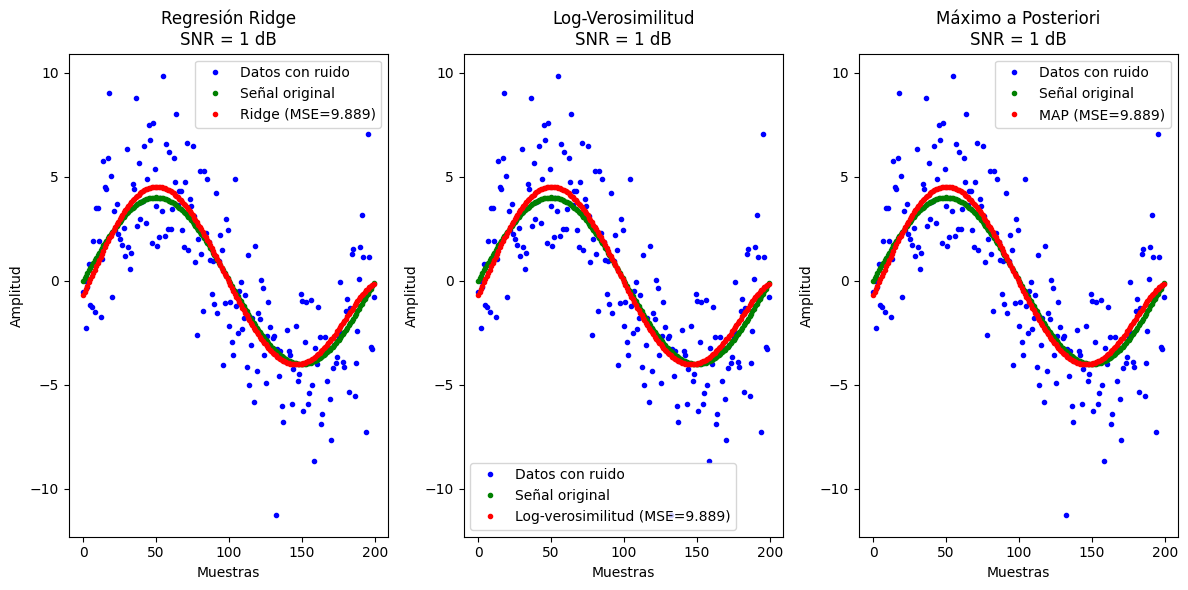

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.31509e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


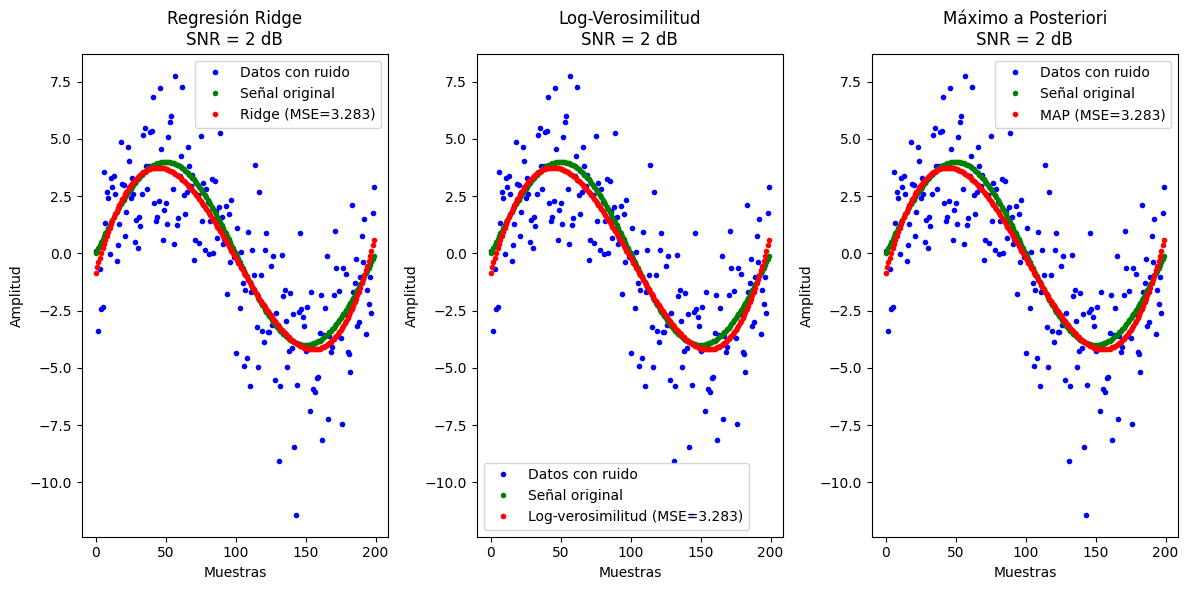

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.31509e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


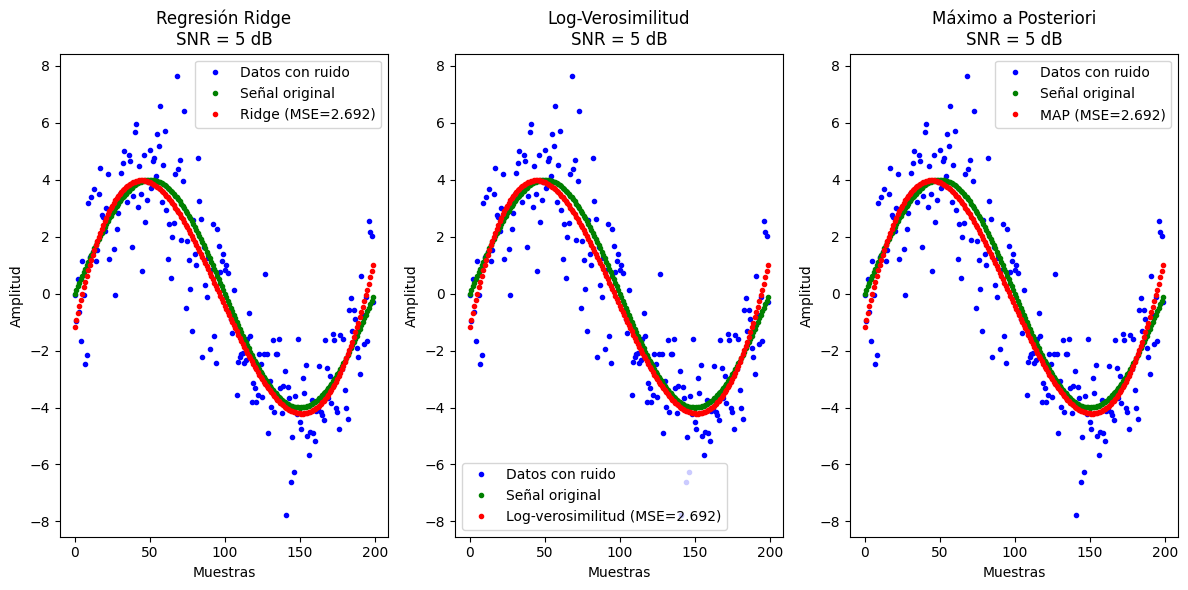

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.31509e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


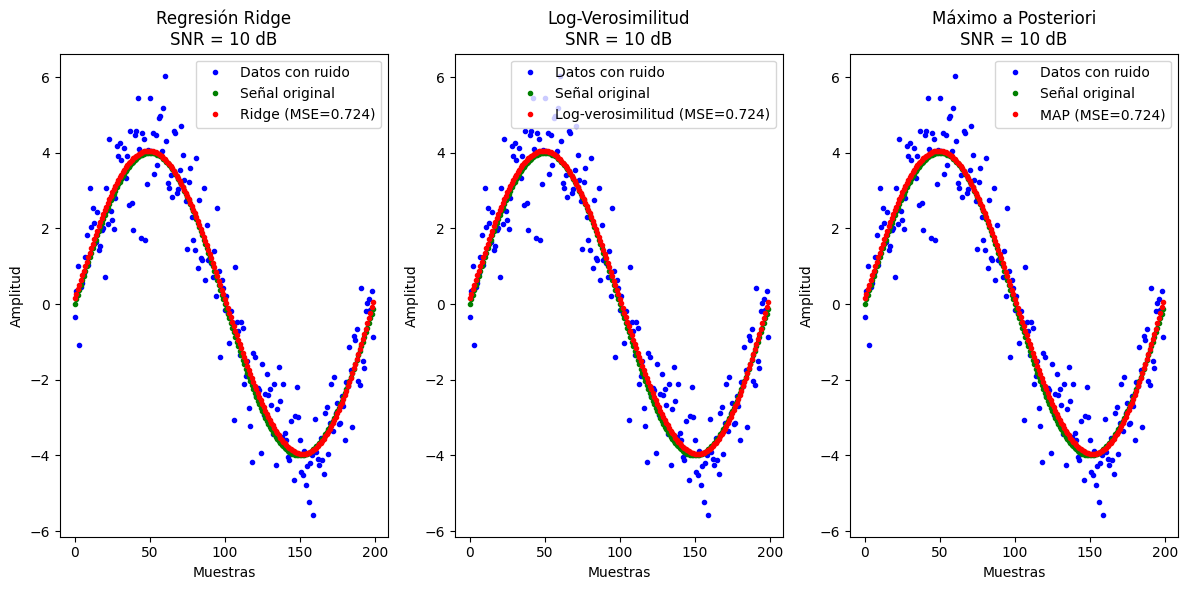

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

###############################################################################
# Función para generar datos sintéticos
# ----------------------------------------------------------------------------
def generar_datos_sinteticos(amplitud: float, num_muestras: int, snr_db: float):
    """
    Genera datos sintéticos con ruido.

    Parámetros
    ----------
    amplitud : float
        Amplitud de la señal original.
    num_muestras : int
        Número de muestras a generar.
    snr_db : float
        Relación señal-ruido (SNR) en decibelios.

    Retorna
    -------
    tiempo : np.ndarray
        Vector de tiempo.
    señal_original : np.ndarray
        Señal original sin ruido.
    señal_con_ruido : np.ndarray
        Señal con ruido añadido.
    """
    tiempo = np.arange(0, num_muestras, 1)  # Crear un vector de tiempo desde 0 hasta num_muestras
    señal_original = amplitud * np.sin(2 * np.pi * tiempo / num_muestras)  # Generar señal sinusoidal
    
    potencia_señal = np.mean(señal_original ** 2)  # Calcular la potencia de la señal original
    snr_lineal = 10 ** (snr_db / 10)  # Convertir SNR de decibelios a escala lineal
    potencia_ruido = potencia_señal / snr_lineal  # Calcular la potencia del ruido en función de la SNR
    ruido = np.random.normal(0, np.sqrt(potencia_ruido), num_muestras)  # Generar ruido gaussiano
    
    señal_con_ruido = señal_original + ruido  # Añadir el ruido a la señal original
    return tiempo, señal_original, señal_con_ruido  # Retornar el vector de tiempo, la señal original y la señal con ruido

###############################################################################
# Función para entrenar y evaluar los modelos de regresión
# ----------------------------------------------------------------------------
def entrenar_y_evaluar_modelos(tiempo: np.ndarray, señal: np.ndarray, grado_polinomio: int = 5, alpha: float = 1e-5):
    """
    Entrena y evalúa modelos de regresión polinómica usando Ridge, log-verosimilitud y MAP.

    Parámetros
    ----------
    tiempo : np.ndarray
        Vector de tiempo.
    señal : np.ndarray
        Señal con ruido a ajustar.
    grado_polinomio : int, opcional
        Grado del polinomio utilizado para la transformación (por defecto es 5).
    alpha : float, opcional
        Parámetro de regularización para el modelo Ridge (por defecto es 1e-5).

    Retorna
    -------
    resultados_ridge : tuple
        Modelo Ridge, error cuadrático medio y predicciones.
    resultados_log : tuple
        Pesos del modelo de log-verosimilitud, error cuadrático medio y predicciones.
    resultados_map : tuple
        Pesos del modelo MAP, error cuadrático medio y predicciones.
    tiempo_polinomico : np.ndarray
        Transformación polinómica del tiempo.
    """
    # Transformación polinómica para capturar la naturaleza no lineal
    polinomio = PolynomialFeatures(degree=grado_polinomio)
    tiempo_polinomico = polinomio.fit_transform(tiempo.reshape(-1, 1))  # Transformar el tiempo en una matriz de características polinómicas
    
    # Dividir datos en conjuntos de entrenamiento (80%) y prueba (20%)
    X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(tiempo_polinomico, señal, test_size=0.2, random_state=42)
    
    # Regresión Ridge para ajustar un modelo polinómico regularizado
    modelo_ridge = Ridge(alpha=alpha, fit_intercept=False)
    modelo_ridge.fit(X_entrenamiento, y_entrenamiento)  # Entrenar el modelo Ridge con los datos de entrenamiento
    predicciones_ridge = modelo_ridge.predict(X_prueba)  # Predecir los valores para el conjunto de prueba
    mse_ridge = mean_squared_error(y_prueba, predicciones_ridge)  # Calcular el error cuadrático medio (MSE) para el modelo Ridge

    # Log-verosimilitud (asumiendo un modelo lineal)
    def log_verosimilitud(X_entrenamiento, y_entrenamiento, alpha):
        # Calcular los pesos usando la fórmula de log-verosimilitud
        return np.linalg.inv(X_entrenamiento.T @ X_entrenamiento + alpha * np.eye(X_entrenamiento.shape[1])) @ X_entrenamiento.T @ y_entrenamiento

    pesos_log = log_verosimilitud(X_entrenamiento, y_entrenamiento, alpha)  # Calcular los pesos del modelo de log-verosimilitud
    predicciones_log = X_prueba @ pesos_log  # Predecir los valores para el conjunto de prueba usando log-verosimilitud
    mse_log = mean_squared_error(y_prueba, predicciones_log)  # Calcular el MSE para el modelo de log-verosimilitud

    # Máximo a Posteriori (MAP)
    def estimacion_map(X_entrenamiento, y_entrenamiento, alpha):
        # Calcular los pesos usando la estimación MAP
        return np.linalg.inv(X_entrenamiento.T @ X_entrenamiento + alpha * np.eye(X_entrenamiento.shape[1])) @ X_entrenamiento.T @ y_entrenamiento

    pesos_map = estimacion_map(X_entrenamiento, y_entrenamiento, alpha)  # Calcular los pesos del modelo MAP
    predicciones_map = X_prueba @ pesos_map  # Predecir los valores para el conjunto de prueba usando MAP
    mse_map = mean_squared_error(y_prueba, predicciones_map)  # Calcular el MSE para el modelo MAP

    # Retornar los resultados de los tres métodos de ajuste
    return (modelo_ridge, mse_ridge, predicciones_ridge), (pesos_log, mse_log, predicciones_log), (pesos_map, mse_map, predicciones_map), tiempo_polinomico

###############################################################################
# Parámetros
# ----------------------------------------------------------------------------
# Solicitar la amplitud de la señal al usuario
amplitud = float(input("Por favor, ingresa la amplitud de la señal: "))

# Solicitar el número de muestras al usuario
num_muestras = int(input("Por favor, ingresa el número de muestras: "))

snr_db_values = [1, 2, 5, 10]  # Valores de SNR en dB para evaluar

# Generar y evaluar para cada valor de SNR
for snr_db in snr_db_values:
    # Generar datos sintéticos para el valor de SNR actual
    tiempo, señal_original, señal_con_ruido = generar_datos_sinteticos(amplitud, num_muestras, snr_db)
    
    # Entrenar y evaluar los modelos de regresión
    (modelo_ridge, mse_ridge, predicciones_ridge), (pesos_log, mse_log, predicciones_log), (pesos_map, mse_map, predicciones_map), tiempo_polinomico = entrenar_y_evaluar_modelos(tiempo, señal_con_ruido)
    
    # Graficar resultados para cada modelo
    plt.figure(figsize=(12, 6))  # Crear una figura de tamaño 12x6
    plt.subplot(1, 3, 1)  # Crear el primer subplot para el modelo Ridge
    plt.plot(tiempo, señal_con_ruido, 'b.', label='Datos con ruido')  # Graficar la señal con ruido
    plt.plot(tiempo, señal_original, 'g.', label='Señal original')  # Graficar la señal original
    plt.plot(tiempo, modelo_ridge.predict(tiempo_polinomico), 'r.', label=f'Ridge (MSE={mse_ridge:.3f})')  # Graficar las predicciones del modelo Ridge
    plt.title(f'Regresión Ridge\nSNR = {snr_db} dB')  # Título del gráfico
    plt.xlabel('Muestras')  # Etiqueta del eje X
    plt.ylabel('Amplitud')  # Etiqueta del eje Y
    plt.legend()  # Mostrar la leyenda

    plt.subplot(1, 3, 2)  # Crear el segundo subplot para el modelo de log-verosimilitud
    plt.plot(tiempo, señal_con_ruido, 'b.', label='Datos con ruido')  # Graficar la señal con ruido
    plt.plot(tiempo, señal_original, 'g.', label='Señal original')  # Graficar la señal original
    plt.plot(tiempo, tiempo_polinomico @ pesos_log, 'r.', label=f'Log-verosimilitud (MSE={mse_log:.3f})')  # Graficar las predicciones del modelo de log-verosimilitud
    plt.title(f'Log-Verosimilitud\nSNR = {snr_db} dB')  # Título del gráfico
    plt.xlabel('Muestras')  # Etiqueta del eje X
    plt.ylabel('Amplitud')  # Etiqueta del eje Y
    plt.legend()  # Mostrar la leyenda

    plt.subplot(1, 3, 3)  # Crear el tercer subplot para el modelo MAP
    plt.plot(tiempo, señal_con_ruido, 'b.', label='Datos con ruido')  # Graficar la señal con ruido
    plt.plot(tiempo, señal_original, 'g.', label='Señal original')  # Graficar la señal original
    plt.plot(tiempo, tiempo_polinomico @ pesos_map, 'r.', label=f'MAP (MSE={mse_map:.3f})')  # Graficar las predicciones del modelo MAP
    plt.title(f'Máximo a Posteriori\nSNR = {snr_db} dB')  # Título del gráfico
    plt.xlabel('Muestras')  # Etiqueta del eje X
    plt.ylabel('Amplitud')  # Etiqueta del eje Y
    plt.legend()  # Mostrar la leyenda

    plt.tight_layout()  # Ajustar el diseño para que no se superpongan los subplots
    plt.show()  # Mostrar la figura con los tres subplots


## **Ejercicio bonificación** 

Presente la animación de actualización del modelo ilustrado en el ejemplo anterior para el estimador de máxima verosimilitud (graficar estimación con incertidumbre).

Repetir el ejemplo de la animación para el estimador Bayesiano para la función senoidal contaminada con ruido Gaussiano utilizando mapeo Polinomial de grado 9.

Incluya la gráfica de la magnitud de los pesos y la matriz covarianza como una imagen.

Para las dos componentes más importentes, repita la animación del ejemplo.

Repita para un mapeo por Gaussianas (RBF) de orden 30.

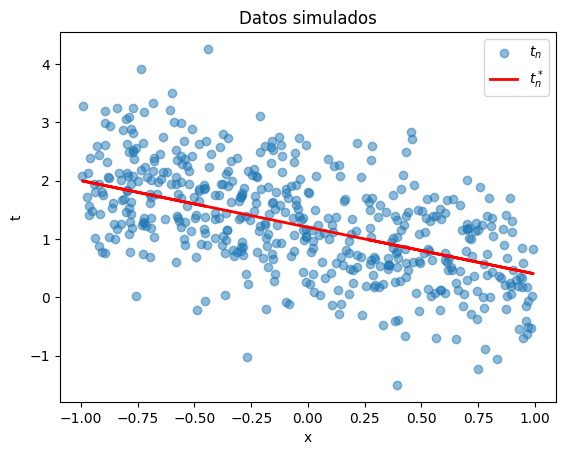

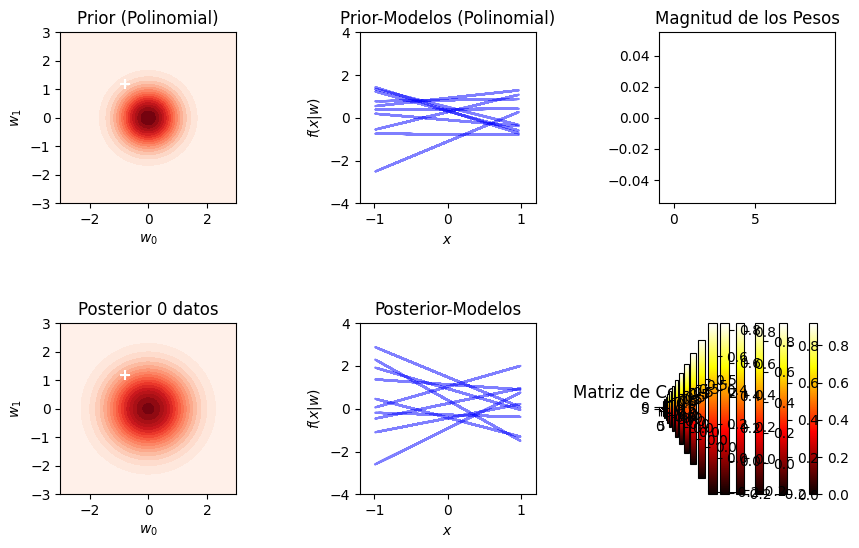

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
from matplotlib import animation, rc
from IPython.display import HTML

# Función para calcular la varianza del ruido a partir de la relación señal-ruido (SNR)
def var_snr(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10.0)  # Convertir SNR de dB a escala lineal
    power_signal = np.mean(signal ** 2)  # Calcular la potencia de la señal
    var_noise = power_signal / snr_linear  # Calcular la varianza del ruido
    return var_noise

# Parámetros de la simulación
snrdB = 5  # Relación señal-ruido en dB
N = 500  # Número de muestras
w_ = np.array([-0.8, 1.2])  # Pesos del modelo original

# Generación de datos
X = np.c_[np.random.uniform(low=-1, high=1, size=N).reshape(N, 1), np.ones((N, 1))]  # Datos de entrada con un término de sesgo
tt = X.dot(w_.T)  # Salida sin ruido (modelo original)
sig_eta = var_snr(tt, snrdB)  # Calcular la varianza del ruido
t = tt + np.sqrt(sig_eta) * np.random.randn(X.shape[0])  # Añadir ruido a la salida

# Visualización de los datos simulados
plt.scatter(X[:, 0], t, label='$t_n$', alpha=0.5)  # Graficar los datos ruidosos
plt.plot(X[:, 0], tt, 'r', label='$t_n^*$', linewidth=2)  # Graficar la salida sin ruido
plt.legend()
plt.title('Datos simulados')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

# Función para graficar la distribución de probabilidad (PDF) 2D
def my_2Dpdf(mu, Sigma, axes, N=100, h=0.02, xlabel_='$w_0$', ylabel_='$w_1$', cmap='Reds', xlim=None, ylim=None):
    pdfx = mn(mu[:2], Sigma[:2, :2])  # Usar solo las primeras dos dimensiones de mu y Sigma
    if xlim is None:
        x_min, x_max = pdfx.mean[0] - 4*np.sqrt(pdfx.cov[0, 0]), pdfx.mean[0] + 4*np.sqrt(pdfx.cov[0, 0])
    else:
        x_min, x_max = xlim[0], xlim[1]
    if ylim is None:
        y_min, y_max = pdfx.mean[1] - 4*np.sqrt(pdfx.cov[1, 1]), pdfx.mean[1] + 4*np.sqrt(pdfx.cov[1, 1])
    else:
        y_min, y_max = ylim[0], ylim[1]
    
    X, Y = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))  # Crear la cuadrícula de puntos
    pos = np.dstack((X, Y))
    Z = pdfx.pdf(pos)  # Calcular la PDF en cada punto de la cuadrícula
    axes.contourf(X, Y, Z, levels=20, cmap=cmap)  # Graficar los contornos de la PDF
    axes.set_xlabel(xlabel_)
    axes.set_ylabel(ylabel_)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    return

# Función para graficar líneas de regresión lineal simuladas
def my_linregsyn(mu, Sigma, axes, xmin=-1, xmax=1, Nmod=10, xlim=[-1.2, 1.2], ylim=[-1.2, 1.2]):
    pdfw = mn(mu[:2], Sigma[:2, :2])  # Usar solo las primeras dos dimensiones de mu y Sigma
    wmod = pdfw.rvs(size=Nmod)  # Generar modelos de regresión a partir de la distribución
    X = np.random.uniform(low=xmin, high=xmax, size=100)  # Generar datos de entrada aleatorios
    t = wmod.dot(np.vstack([X, np.ones(X.shape[0])]))  # Calcular las salidas para cada modelo
    axes.plot(X, t.T, c='b', alpha=0.5)  # Graficar las líneas de regresión
    axes.set_xlabel('$x$')
    axes.set_ylabel('$f(x|w)$')
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    return

# Función para actualizar la distribución posterior en un modelo bayesiano
def my_posterior_update(X, t, sig_eta, sig_w, tol=1e-10):
    lambdaR = sig_eta / sig_w  # Cociente de la varianza del ruido y la varianza del prior
    SNinv = X.T.dot(X) + lambdaR * np.eye(X.shape[1])  # Inversa de la matriz de covarianza del posterior
    val, vec = np.linalg.eigh(SNinv)  # Descomposición en valores y vectores propios
    ind = val > tol  # Filtrar valores propios pequeños
    SN = vec[:, ind].dot(np.diag(1 / val[ind])).dot(vec[:, ind].T)  # Calcular la matriz de covarianza del posterior
    mN = np.squeeze(SN.dot(X.T.dot(t)))  # Calcular la media del posterior
    return mN, SN

# Función para actualizar la predicción en un modelo bayesiano
def my_predictiva_update(xnew, mN, SN, sig_eta):
    mnew = xnew.dot(mN)  # Calcular la predicción media
    signew = np.diag(sig_eta * np.eye(xnew.shape[0]) + xnew.dot(SN).dot(xnew.T))  # Calcular la incertidumbre en la predicción
    return mnew, signew

# Mapeo polinomial de grado 9
degree = 9
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X[:, 0].reshape(-1, 1))  # Generar las características polinomiales a partir de X

# Vector de muestreo aleatorio de datos en X
ind = np.random.randint(0, X_poly.shape[0], size=X_poly.shape[0])

# Definir prior pesos
mu_w = np.zeros(X_poly.shape[1])  # Media del prior inicial (cero)
sig_w = 0.5  # Varianza del prior
S_w = sig_w * np.eye(len(mu_w))  # Matriz de covarianza del prior

# Límites gráficos
wxlim = [-3, 3]  # Límites para graficar la PDF en los pesos
wylim = [-3, 3]
xlim = [-1.2, 1.2]  # Límites para graficar las predicciones en el espacio de entrada
ylim = [-4, 4]

# Figura y ejes para la animación
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax[0, 2].axis('off')  # Desactivar uno de los ejes

# Variables globales para guardar los valores de mN y SN
mN, SN = None, None

# Función para la actualización de la animación con mapeo polinomial
def update_polynomial(i):
    global mN, SN  # Acceder a las variables globales
    ax[0, 0].clear()
    ax[0, 1].clear()
    ax[1, 0].clear()
    ax[1, 1].clear()
    ax[1, 2].clear()

    # Graficar el prior en el espacio de pesos
    my_2Dpdf(mu_w, S_w, axes=ax[0, 0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mu_w, S_w, axes=ax[0, 1], xlim=xlim, ylim=ylim)

    # Actualizar la distribución posterior con los datos observados
    mN, SN = my_posterior_update(X_poly[ind[:i]], t[ind[:i]], sig_eta, sig_w, tol=1e-10)
    my_2Dpdf(mN, SN, axes=ax[1, 0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mN, SN, axes=ax[1, 1], xlim=xlim, ylim=ylim)
    ax[1, 1].scatter(X[ind[:i], 0], t[ind[:i]], c='r', marker='.')
    
    # Graficar los pesos originales
    ax[1, 0].scatter(w_[0], w_[1], marker='+', s=60, c='w')
    ax[0, 0].scatter(w_[0], w_[1], marker='+', s=60, c='w')

    # Calcular y graficar la predicción con incertidumbre
    mnew, snew = my_predictiva_update(X_poly, mN, SN, sig_eta)
    ax[1, 2].plot(X[:, 0], tt, c='g')  # Línea de la verdad del modelo sin ruido
    ax[1, 2].scatter(X[ind[:i], 0], t[ind[:i]], c='r', marker='.')
    ax[1, 2].plot(X[:, 0], mnew, c='b')
    ii = np.argsort(X[:, 0])
    ax[1, 2].fill_between(X[ii, 0].ravel(), mnew[ii].ravel() - 2 * snew[ii],
                          mnew[ii].ravel() + 2 * snew[ii], alpha=0.5)
    ax[1, 2].set_xlim(xlim)
    ax[1, 2].set_ylim(ylim)

    # Añadir títulos a las gráficas
    ax[0, 0].set_title('Prior (Polinomial)')
    ax[0, 1].set_title('Prior-Modelos (Polinomial)')
    ax[1, 0].set_title('Posterior ' + str(i) + ' datos')
    ax[1, 1].set_title('Posterior-Modelos')
    ax[1, 2].set_title('Predictiva')
    plt.subplots_adjust(wspace=0.7, hspace=0.7)

# Crear la animación utilizando la función de actualización
anim_poly = animation.FuncAnimation(fig, update_polynomial, frames=np.array([0, 1, 2, 3, 5, 7, 9, 10, 15, 20, 25, 50, 100, 250, 500]), blit=False)
rc('animation', html='jshtml')
HTML(anim_poly.to_jshtml())

# Mapeo por RBF de orden 30
rbf_sampler = RBFSampler(gamma=1, n_components=30, random_state=42)
X_rbf = rbf_sampler.fit_transform(X[:, 0].reshape(-1, 1))  # Generar características RBF a partir de X

# Actualizar las funciones para que utilicen el nuevo X_rbf
ind = np.random.randint(0, X_rbf.shape[0], size=X_rbf.shape[0])

# Función para la actualización de la animación con mapeo RBF
def update_rbf(i):
    global mN, SN  # Acceder a las variables globales
    ax[0, 0].clear()
    ax[0, 1].clear()
    ax[1, 0].clear()
    ax[1, 1].clear()
    ax[1, 2].clear()

    # Graficar el prior en el espacio de pesos
    my_2Dpdf(mu_w, S_w, axes=ax[0, 0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mu_w, S_w, axes=ax[0, 1], xlim=xlim, ylim=ylim)

    # Actualizar la distribución posterior con los datos observados
    mN, SN = my_posterior_update(X_rbf[ind[:i]], t[ind[:i]], sig_eta, sig_w, tol=1e-10)
    my_2Dpdf(mN, SN, axes=ax[1, 0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mN, SN, axes=ax[1, 1], xlim=xlim, ylim=ylim)
    ax[1, 1].scatter(X[ind[:i], 0], t[ind[:i]], c='r', marker='.')
    
    # Graficar los pesos originales
    ax[1, 0].scatter(w_[0], w_[1], marker='+', s=60, c='w')
    ax[0, 0].scatter(w_[0], w_[1], marker='+', s=60, c='w')

    # Calcular y graficar la predicción con incertidumbre
    mnew, snew = my_predictiva_update(X_rbf, mN, SN, sig_eta)
    ax[1, 2].plot(X[:, 0], tt, c='g')  # Línea de la verdad del modelo sin ruido
    ax[1, 2].scatter(X[ind[:i], 0], t[ind[:i]], c='r', marker='.')
    ax[1, 2].plot(X[:, 0], mnew, c='b')
    ii = np.argsort(X[:, 0])
    ax[1, 2].fill_between(X[ii, 0].ravel(), mnew[ii].ravel() - 2 * snew[ii],
                          mnew[ii].ravel() + 2 * snew[ii], alpha=0.5)
    ax[1, 2].set_xlim(xlim)
    ax[1, 2].set_ylim(ylim)

    # Añadir títulos a las gráficas
    ax[0, 0].set_title('Prior (RBF)')
    ax[0, 1].set_title('Prior-Modelos (RBF)')
    ax[1, 0].set_title('Posterior ' + str(i) + ' datos')
    ax[1, 1].set_title('Posterior-Modelos')
    ax[1, 2].set_title('Predictiva')
    plt.subplots_adjust(wspace=0.7, hspace=0.7)

# Crear la animación utilizando la función de actualización
anim_rbf = animation.FuncAnimation(fig, update_rbf, frames=np.array([0, 1, 2, 3, 5, 7, 9, 10, 15, 20, 25, 50, 100, 250, 500]), blit=False)
rc('animation', html='jshtml')
HTML(anim_rbf.to_jshtml())

# Función para graficar la magnitud de los pesos y la matriz de covarianza
def plot_weights_and_covariance(mN, SN, ax_weights, ax_cov):
    weights_magnitude = np.abs(mN)  # Calcular la magnitud de los pesos
    ax_weights.clear()
    ax_weights.bar(range(len(weights_magnitude)), weights_magnitude)  # Graficar la magnitud de los pesos
    ax_weights.set_title('Magnitud de los Pesos')
    
    ax_cov.clear()
    im = ax_cov.imshow(SN, cmap='hot', interpolation='nearest')  # Graficar la matriz de covarianza
    ax_cov.set_title('Matriz de Covarianza')
    fig.colorbar(im, ax=ax_cov)  # Añadir barra de color
    return

# Incorporar la gráfica de la magnitud de los pesos y la matriz de covarianza en la animación
def update_with_weights(i):
    update_polynomial(i)  # O update_rbf(i) dependiendo del mapeo que se quiera utilizar
    plot_weights_and_covariance(mN, SN, ax[0, 2], ax[1, 2])  # Graficar la magnitud de los pesos y la covarianza

# Crear la animación con la gráfica de los pesos y la matriz de covarianza
anim_with_weights = animation.FuncAnimation(fig, update_with_weights, frames=np.array([0, 1, 2, 3, 5, 7, 9, 10, 15, 20, 25, 50, 100, 250, 500]), blit=False)
rc('animation', html='jshtml')
HTML(anim_with_weights.to_jshtml())
